In [1]:
%run loadRat_documentation.ipynb

import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter as smooth

import os
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

## Display the preprocessing steps
  

### Load data

In [3]:
#run only if inside this notebook (do not execute if "%run this_notebook")
if "__file__" not in dir():
    
    param={
        "goalTime":7,
        "treadmillRange":[0,90],
        "maxTrialDuration":20,
        "interTrialDuration":10,
        
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        
        "binSize":0.1,
        "sigmaSmoothPosition":0.1, 
    }       
    root="/data"
    animal="Rat034"
    experiment="Rat034_2015_03_01_13_26"
    
    #animal="Rat034"
    #experiment="Rat034_2015_03_04_10_04"
    
    animal="Rat001"
    experiment="Rat001_2011_04_20_10_56"

    data=PreprocessTreadmillOn(root,animal,experiment,param=param,redo=False)
    print(data.trialOffset)
    

behavior data loaded from /data/Rat001/Experiments/Rat001_2011_04_20_10_56/Analysis/rawbehaviordata.p
trial 1 bad video quality, number of jumps: 423
20.0


### Position of the animal at the entrance time 

does not work well with pavel data


In [4]:
positionAtEntrance=[]
for trial in data.trials[1:]:
    e=data.entranceTime[trial]
    time=data.timeTreadmill[trial]
    pos=data.position[trial]
    
    if e>=(data.maxTrialDuration[trial]-1):
        continue
    try:
        indexEntrance=np.where(time>=e)[0][0]
    except IndexError:
        continue
    positionAtEntrance.append(pos[indexEntrance])
    
print("mean",np.mean(positionAtEntrance))
print("max",max(positionAtEntrance))
print("std",np.std(positionAtEntrance))

mean 32.4001328291
max 59.14286
std 14.5307841024


### Positions Raw and processed

[1]


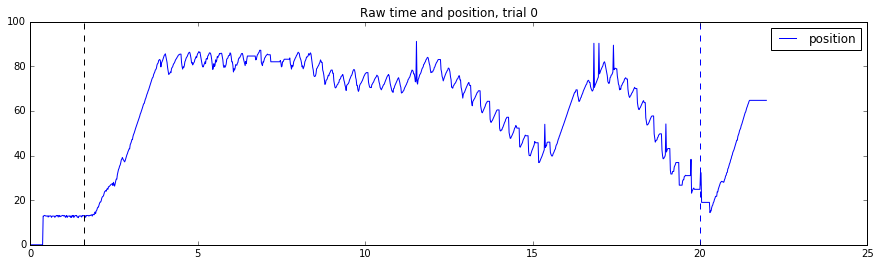

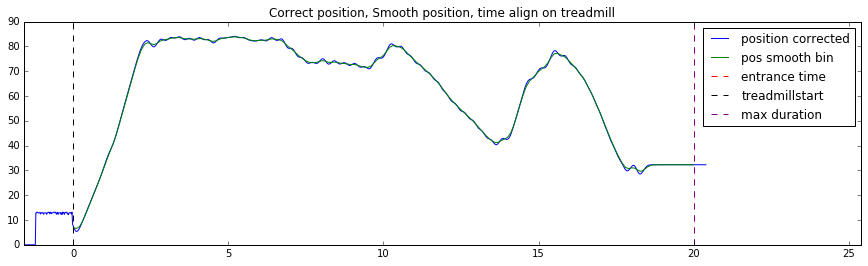

In [5]:
print(data.trialNotTracked)
trial=0

plt.figure(figsize=(15,4))
plt.plot(data.rawTime[trial],data.rawPosition[trial],"b-",label="position")
plt.title("Raw time and position, trial %s"%trial)
plt.legend()
plt.axvline(data.maxTrialDuration[trial],ls="--")
plt.axvline(data.treadmillStartTime[trial]-data.cameraStartTime[trial],linestyle="--",
            color="black",label="treadmillstart")

plt.figure(figsize=(15,4))
plt.plot(data.timeTreadmill[trial],data.position[trial],label="position corrected")
plt.plot(data.timeBin,data.positionBin[trial],"g-",label="pos smooth bin")
plt.axvline(data.entranceTime[trial],linestyle="--",color="red",label="entrance time")
plt.axvline(0,linestyle="--",color="black",label="treadmillstart")
plt.title("Correct position, Smooth position, time align on treadmill")

plt.xlim([data.cameraStartTime[trial]-data.treadmillStartTime[trial],max(data.timeTreadmill[trial])+5])
plt.axvline(data.maxTrialDuration[trial],ls="--",color="purple",label="max duration")
plt.legend()

### Plot: Detecting end of trajectories

In [8]:
def plot_detect_end(data,trial):
    pos=data.position[trial]
    time=data.timeTreadmill[trial]
    end,timeEnd=data.get_index_time_end_of_trial(pos,time)
    plt.plot(time,pos)
    if end is not None:
        plt.axvline(timeEnd,color="red",label="detected end")
    else:
        timeEnd="undetected"
    plt.axvline(data.entranceTime[trial],color="green",label="entrance time")
    plt.title("Trial %s, entrance Time= %s s, detected end= %s s"%(trial,data.entranceTime[trial],timeEnd))
    plt.legend();
    return
 
def plot_details_detect_end(data,trial):
    plt.figure(figsize=(10,7))
    
    backPos=data.endTrial_backPos 
    frontPos=data.endTrial_frontPos
    minTimeSec=data.endTrial_minTimeSec
    position=data.position[trial]
    time=data.timeTreadmill[trial]
    
    plt.plot(time,position,"b-",label="correct position")
    plt.axvline(minTimeSec,linestyle="--",color="green",label="min time")
    plt.axhline(backPos,linestyle="--",color="red",label="back position")
    plt.axhline(frontPos,color="purple",linestyle="--",label="front position")
    
    if np.sum(position>=backPos)==0:
         #skip trial if the animal never goes above backPos centimeters (=back of the treadmill)
        print("never goes back")
        return None
    else:
        #find first occurence of "being above backPos" (back of the treadmill)
        firstTimeAboveX=time[np.where(position>=backPos)[0][0]]
    
    plt.plot(firstTimeAboveX,position[np.where(position>=backPos)[0][0]],"ko",label="first time above backPos")

    #for all position, find if it's a minima or not (True/False)
    # <= or won't catch minima if there is a plateau at the end
    isMinima=np.r_[False,position[1:] < position[:-1]] & np.r_[position[:-1]<=position[1:],True]

    plt.plot(time[isMinima],position[isMinima],"ro",label="bad minimas")
    
    #condition1: position<=frontPos (position is near front of the treadmill)
    positionIsLow=position<=frontPos
    #condition2: time>minTimeSec (don't keep early minimas)
    timeIsAboveMin=time>=minTimeSec
    #condition3: animal has been on the back of the treadmill once (above backPos)
    timeIsAfterReachBack=time>firstTimeAboveX
    #apply the conditions
    isMinima=isMinima & positionIsLow & timeIsAboveMin & timeIsAfterReachBack
       
    plt.plot(time[isMinima],position[isMinima],"go",label="good minimas")
    plt.legend(bbox_to_anchor=(1.8, 1));
    
    try:
        firstMinimaIndex=np.where(isMinima==True)[0][0]
        #look for a minima before, in case of a nearly flat plateau
        minPos=position[firstMinimaIndex]+0.5 #position at the minima
        newIndex=firstMinimaIndex
        while (position[newIndex]<=minPos) and (newIndex>=0):
            newIndex=newIndex-1   
        print(firstMinimaIndex,newIndex)
        plt.plot(time[newIndex],position[newIndex],"o",color="orange",label="selected minima")
        
    except IndexError:
        firstMinimaIndex=None
        


#To plot for one trial
trial=146
plot_details_detect_end(data,trial)


#To plot for every trial:
if False:
    for trial in data.goodTrials:
        plt.figure(trial)
        plot_detect_end(data,trial)
        plt.ylim([0,90])

KeyError: 146

### Plot trials aligned to end

In [ ]:
def get_positions_array_end(data,minTime=-5,onlyGood=False,raw=False):
    '''
    Returns array of position, align on detected end, between minTime and zero (0=end)
    '''
    if raw:
        posDict=data.rawPosition
    else:
        posDict=data.position
    cs=data.cameraSamplingRate
    size=int(abs(minTime*cs))
    
    allTraj=[]
    for trial in posDict:
        if onlyGood and (trial not in data.goodTrials):
            continue
        endIndex=data.indexEndTrial[trial]
        if (endIndex is None) or np.isnan(endIndex):
            continue 
        startIndex=max(data.startFrame[trial],int(endIndex+(minTime*cs)))
        pos=posDict[trial][startIndex:endIndex]
        #if too short, pad the start with a plateau (Nan would cause trouble to compute speed later)
        if len(pos)<(size):
            pos=np.append([pos[0]] * (size-len(pos)),pos)
        allTraj.append(pos)
    allTraj=np.asarray(allTraj)
    return allTraj

def plot_position_align_end(data,minTime=-5,xUpLimit=5,onlyGood=False):
    '''
    [minTime to 0] is the time range to measure the correlation, with 0=detected end
    xUpLimit is the x axis max limit
    onlyGood is whether to consider only good trials
    nb: data.timeEndTrial is computed with data.position
    '''
    cs=data.cameraSamplingRate
    for trial in data.position:
        end=data.timeEndTrial[trial]
        if end is None:
            continue
        color="green"
        if trial not in data.goodTrials:
            if onlyGood:
                continue
            color="red"
        plt.plot(data.timeTreadmill[trial]-end,data.position[trial],color=color)
     
    plt.xlim([minTime,xUpLimit])
    plt.ylabel("Position (cm/s)")
    plt.xlabel("Time relative to detected end (s)")
    plt.axvline(0,color="b",ls="--")

    w="correct " if onlyGood else ""
    
    allTraj=get_positions_array_end(data,minTime=minTime,onlyGood=onlyGood,raw=False)
    if allTraj.shape[0]<3:
        plt.title("End of %strials"%w)
        return None
    corMatrix=np.corrcoef(allTraj)
    coeff=corMatrix[np.triu_indices(corMatrix.shape[0],1)]
    med=np.nanmedian(coeff)
    plt.title("End of %strials, median last %ss r=%.2f" %(w,abs(minTime),med))    
    return med

if "__file__" not in dir():
    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plot_position_align_end(data,onlyGood=False)
    plt.subplot(222)
    plot_position_align_end(data,onlyGood=True)

### Plot steps of position pre processing for one trial

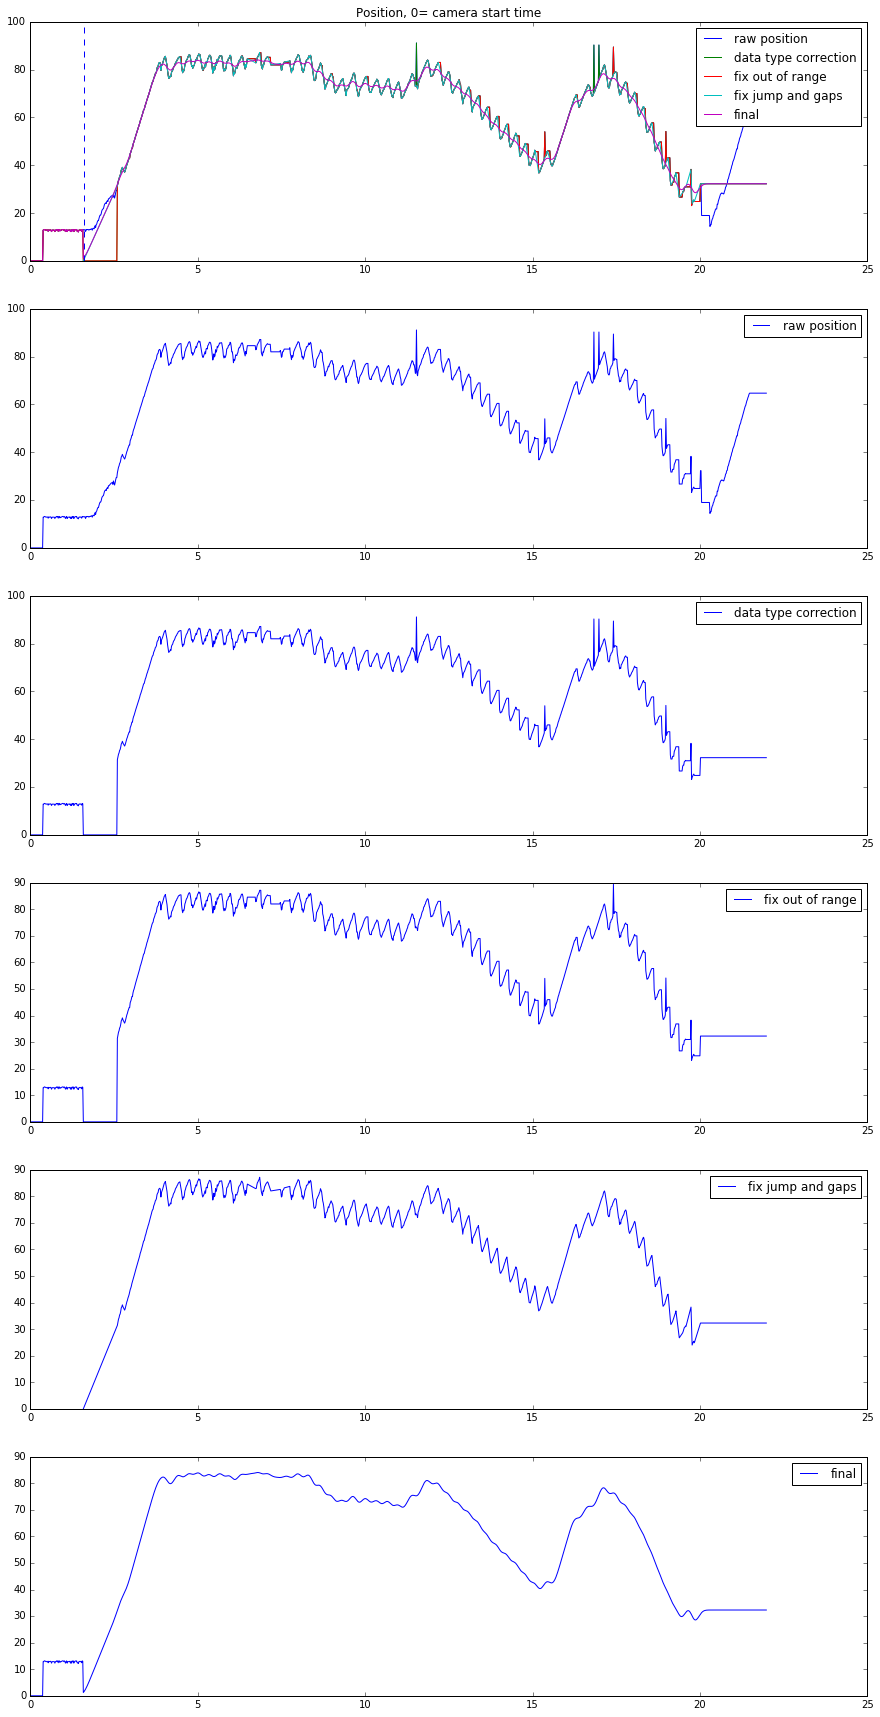

In [6]:
def processing(data,trial):
    
    #plot raw
    position=data.rawPosition[trial]
    time=data.rawTime[trial]
    plt.subplot(611)
    plt.plot(time,position,label="raw position")
    plt.subplot(612)
    plt.plot(time,position,label="raw position")
    plt.legend()
    
    #correction specific to data type
    if data.dataType=="behav_param":
        nbPosition=len(np.unique(np.around(position)))
        if nbPosition<5:
            print("trial %s: only %s unique positions, skip"%(trial,nbPosition))
            return
        pos=position
    else:
        if data.entranceTime[trial]>=data.goalTime[trial]:
            posCorrectEnd,lastGoodValue = data.correct_ending(position,trial) 
        else:
            posCorrectEnd=position  
        #correct starting artefacts (pavel only)
        if data.dataType=="pavel":
            posCorrectStart,firstGoodValue=data.correct_starting(posCorrectEnd,trial,mindiff=data.positionDiffRange[0])
        else:
            posCorrectStart=posCorrectEnd 
        pos=posCorrectStart
        
    plt.subplot(611)
    plt.plot(time,pos,label="data type correction")
    plt.subplot(613)
    plt.plot(time,pos,label="data type correction")
    plt.legend()
    
    startFrame=int(data.startFrame[trial])
    
    #correct positions out of the treadmill range
    posCorrectRange = data.correct_outofrange(pos)
    plt.subplot(611)
    plt.plot(time,posCorrectRange,label="fix out of range")      
    plt.subplot(614)
    plt.plot(time,posCorrectRange,label="fix out of range") 
    plt.legend()
        
    #following fixes should only be apply during treadmill on
    posCutted=posCorrectRange[startFrame:] 

    #find jump frames and transient frames
    jumpFrame,transientFrame=data.detect_jump_transient(posCutted,data.positionDiffRange[1])            
    #remove trial if badly tracked (too much jumps)
    nJump=len(jumpFrame)
    if nJump>data.nbJumpMax:
        print("trial %s bad video quality, number of jumps: %s"%(trial,nJump))
        return           
    #correct lost tracking
    borderCorrection=[posCutted[0],posCutted[-1]]
    posFixed=data.correct_trackingbreak(posCutted,borderCorrection)
    #correct jumps
    border=[posFixed[0],posFixed[-1]]
    posFixed2=data.correct_jumps(posFixed,data.positionDiffRange[1],border)    
    
    plt.subplot(611)
    plt.plot(time[startFrame:],posFixed2,label="fix jump and gaps")
    plt.subplot(615)
    plt.plot(time[startFrame:],posFixed2,label="fix jump and gaps")
    plt.legend()

    #smooth
    cs=data.cameraSamplingRate
    posSmooth=data.correct_outofrange(smooth(posFixed2,data.sigmaSmoothPosition*cs,mode="nearest"))
            
    #re-attached the beginning (pos between camera and treadmill starts)
    posAll=np.append(posCorrectRange[:startFrame],posSmooth)  
    
    plt.subplot(611)
    plt.plot(time,posAll,label="final")
    plt.subplot(616)
    plt.plot(time,posAll,label="final")
    plt.legend()
    
    plt.subplot(611)
    plt.title("Position, 0= camera start time")
    plt.legend()
    
trial=0
plt.figure(figsize=(15,30))
processing(data,trial)

plt.axvline(data.treadmillStartTime[trial]-data.cameraStartTime[trial],ls="--")
#plt.xlim([0,4])